In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 1. Define the DeepONet Architecture
class DeepONet(nn.Module):
    def __init__(self, branch_input_size, trunk_input_size, latent_dim):
        super(DeepONet, self).__init__()
        # Branch Net: Processes the input function (u(x))
        self.branch_net = nn.Sequential(
            nn.Linear(branch_input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        # Trunk Net: Processes the query point (x)
        self.trunk_net = nn.Sequential(
            nn.Linear(trunk_input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        # Bias term for the output (optional, but common in DeepONet)
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, u_input, x_eval):
        # u_input: (batch_size, branch_input_size) - discretized function
        # x_eval: (batch_size, trunk_input_size) - evaluation points
        branch_output = self.branch_net(u_input) # (batch_size, latent_dim)
        trunk_output = self.trunk_net(x_eval)   # (batch_size, latent_dim)
        # Element-wise product and sum
        output = torch.sum(branch_output * trunk_output, dim=1, keepdim=True) + self.bias
        return output

# 2. Data Generation
# Domain for x
num_points = 50 # Number of points to discretize the input function and output evaluation
x_domain = torch.linspace(0, 1, num_points).view(-1, 1)

# Training functions: u(x) and their second derivatives G(u)(x)
# Function 1: u1(x) = x^3, G(u1)(x) = 6x
u1 = lambda x: x**3
d2u1_dx2 = lambda x: 6 * x

# Function 2: u2(x) = x**6, G(u2)(x) = 30 * x**4
u2 = lambda x: x**6
d2u2_dx2 = lambda x: 30 * x**4

# Create training data
# We'll create samples where each sample is (discretized u, evaluation x_point, G(u)(x_point))
# The model will learn to map (discretized u, x_point) -> G(u)(x_point)

# For each function, create all combinations of input function values and evaluation points
# This forms a "dataset" of (input_function_snapshot, query_point, output_value) tuples

all_u_inputs = []
all_x_evals = []
all_targets = []

# Data for x^3
u1_values_at_points = u1(x_domain).T # (1, num_points) - this is the "snapshot" of u1
for i in range(num_points):
    all_u_inputs.append(u1_values_at_points) # The same snapshot for all evaluation points
    all_x_evals.append(x_domain[i].view(1, 1)) # Each evaluation point
    all_targets.append(d2u1_dx2(x_domain[i]).view(1, 1)) # Target at that evaluation point

# Data for x^6
u2_values_at_points = u2(x_domain).T # (1, num_points)
for i in range(num_points):
    all_u_inputs.append(u2_values_at_points)
    all_x_evals.append(x_domain[i].view(1, 1))
    all_targets.append(d2u2_dx2(x_domain[i]).view(1, 1))

# Concatenate all data
train_u_input = torch.cat(all_u_inputs, dim=0).float()
train_x_eval = torch.cat(all_x_evals, dim=0).float()
train_target = torch.cat(all_targets, dim=0).float()

# 3. Model Initialization, Loss, and Optimizer
latent_dim = 64
model = DeepONet(branch_input_size=num_points, trunk_input_size=1, latent_dim=latent_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 4. Training Loop
epochs = 5000 # Number of training epochs
print("Starting training...")
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(train_u_input, train_x_eval)
    loss = criterion(outputs, train_target)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

print("Training complete.")




Starting training...
Epoch [500/5000], Loss: 0.003233
Epoch [1000/5000], Loss: 0.000250
Epoch [1500/5000], Loss: 0.000139
Epoch [2000/5000], Loss: 0.000074
Epoch [2500/5000], Loss: 0.000172
Epoch [3000/5000], Loss: 0.000041
Epoch [3500/5000], Loss: 0.000043
Epoch [4000/5000], Loss: 0.000034
Epoch [4500/5000], Loss: 0.000035
Epoch [5000/5000], Loss: 0.000032
Training complete.


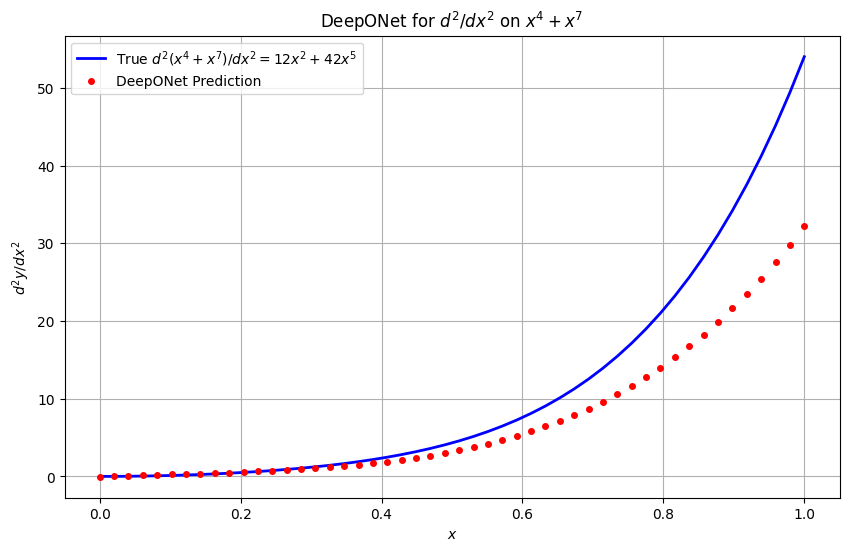

In [8]:
# 5. Testing with x^4 + x^7
test_function = lambda x: x**4 + x**7
true_d2_test_function_dx2 = lambda x: 12 * x**2 + 42 * x**5

test_u_input = test_function(x_domain).T.float() # Snapshot of x^4 + x^7
test_x_eval = x_domain.float()                     # All evaluation points
true_test_target = true_d2_test_function_dx2(x_domain).float() # True second derivative values

model.eval() # Set model to evaluation mode
with torch.no_grad():
    # To get predictions for all x_domain points, we need to create a batch
    # where the same u_input is repeated for each x_eval point.
    # The current DeepONet implementation expects batch_size for u_input and x_eval
    predicted_output = model(test_u_input.repeat(num_points, 1), test_x_eval)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(x_domain.numpy(), true_test_target.numpy(), label='True $d^2(x^4+x^7)/dx^2 = 12x^2 + 42x^5$', color='blue', linewidth=2)
plt.plot(x_domain.numpy(), predicted_output.numpy(), 'o', label='DeepONet Prediction', color='red', markersize=4)
plt.title('DeepONet for $d^2/dx^2$ on $x^4 + x^7$')
plt.xlabel('$x$')
plt.ylabel('$d^2y/dx^2$')
plt.legend()
plt.grid(True)
plt.show()